### Data Collection and Pre-processing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt  
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
# Defining the image size, batch size, RGB channels and Epochs
IMG_SIZE = 524
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
# Loading the different images in different classes
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Waste",
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 4752 files belonging to 9 classes.


In [4]:
# Displaying the classes
cls_name = dataset.class_names
cls_name

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [5]:
# Displaying the images in each batch where each batch roughly has around 149 images
len(dataset)

149

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())     # Converting the tesor to numpy

(32, 524, 524, 3)
[2 3 1 7 4 2 6 6 1 0 3 6 6 8 3 5 6 6 3 5 7 3 5 6 6 6 0 3 1 3 7 8]


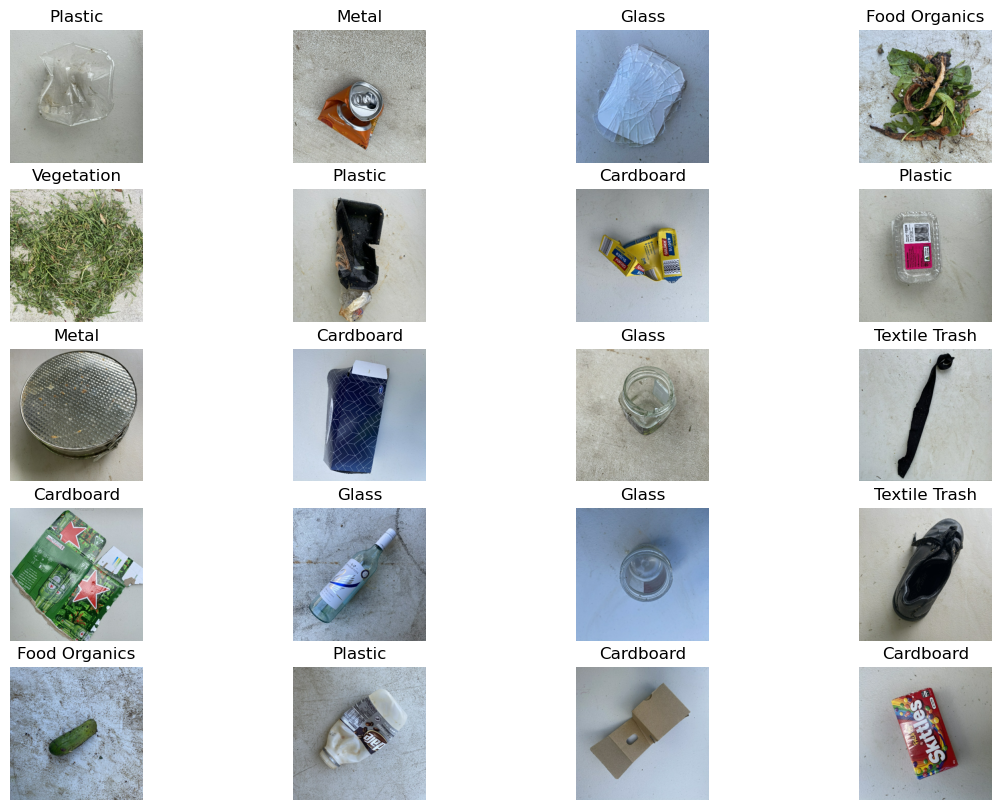

In [9]:
plt.figure(figsize = (14, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range (20):
        ax = plt.subplot(5, 4, i+1)             # Defining the rows and columns for displaying
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(cls_name[label_batch[i]])
        plt.axis("off")

In [10]:
# Taking 50% of the dataset for training
train_size = 0.5
len(dataset) * train_size

74.5

In [11]:
train_dataset = dataset.take(75)
len(train_dataset)

75

In [12]:
test_dataset = dataset.skip(75)
len(test_dataset)

74

In [13]:
# Taking 20% of the dataset for validation
validation_size = 0.20
len(dataset) * validation_size

29.8

In [14]:
validation_dataset = test_dataset.take(30)
len(validation_dataset)

30

In [15]:
# Taking 30% of the dataset for testing
test_dataset = test_dataset.skip(30)
len(test_dataset)

44

In [16]:
def get_dataset_partitions_tf(dataset, train_split = 0.5, validation_split = 0.20, test_split = 0.30,
                              shuffle = True, shuffle_size = 10000):
    
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 45)
        
    train_size = int(train_split * dataset_size)
    validation_size = int(validation_split * dataset_size)
    
    train_dataset = dataset.take(train_size)
    
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    return train_dataset, validation_dataset, test_dataset

In [17]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [18]:
# Training size
print("Training Dataset Size:", len(train_dataset))

# Validation size
print("Validation Dataset Size:", len(validation_dataset))

# Testing size
print("Testing Dataset Size:", len(test_dataset))

Training Dataset Size: 74
Validation Dataset Size: 29
Testing Dataset Size: 46


In [19]:
# Pefetch - improve performance, when GPU is training one batch, CPU will be loading another batch
# Cache - saves time, as the result is already saved
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Rescaling, if the image is not of size 256X256, the Rescaling(IMG_SIZE, IMG_SIZE) will take care of it
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building

### Convolution Neural Networks - CNN

In [22]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_cls = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size= (3, 3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size= (3, 3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3, 3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_cls, activation='softmax'),     # softmax - to normalize the probability of the classes
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 524, 524, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 524, 524, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 522, 522, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 261, 261, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 259, 259, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 129, 129, 64)        0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [25]:
record = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_dataset
)

Epoch 1/50


2024-01-13 18:54:01.295825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 104 of 10000
2024-01-13 18:54:08.475121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-01-13 18:54:08.702493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


74/74 [==============================] - ETA: 0s - loss: 3.6300 - accuracy: 0.2088

2024-01-13 18:58:33.507826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 87 of 10000
2024-01-13 18:58:42.567723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-01-13 18:58:42.928836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


74/74 [==============================] - 314s 4s/step - loss: 3.6300 - accuracy: 0.2088 - val_loss: 2.0216 - val_accuracy: 0.2457
Epoch 2/50
74/74 [==============================] - 296s 4s/step - loss: 1.8954 - accuracy: 0.2993 - val_loss: 1.8292 - val_accuracy: 0.3211
Epoch 3/50
74/74 [==============================] - 301s 4s/step - loss: 1.7537 - accuracy: 0.3512 - val_loss: 1.7957 - val_accuracy: 0.3718
Epoch 4/50
74/74 [==============================] - 299s 4s/step - loss: 1.6003 - accuracy: 0.4043 - val_loss: 1.7883 - val_accuracy: 0.3427
Epoch 5/50
74/74 [==============================] - 298s 4s/step - loss: 1.5961 - accuracy: 0.4141 - val_loss: 1.7019 - val_accuracy: 0.3578
Epoch 6/50
74/74 [==============================] - 298s 4s/step - loss: 1.5622 - accuracy: 0.4256 - val_loss: 1.6436 - val_accuracy: 0.3825
Epoch 7/50
74/74 [==============================] - 297s 4s/step - loss: 1.5016 - accuracy: 0.4456 - val_loss: 1.5212 - val_accuracy: 0.4267
Epoch 8/50
74/74 [======

In [26]:
scores = model.evaluate(test_dataset)

2024-01-13 23:51:20.473811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 90 of 10000
2024-01-13 23:51:30.164147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-01-13 23:51:30.463691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


46/46 [==============================] - 60s 845ms/step - loss: 1.0574 - accuracy: 0.6386


In [27]:
# In the below list 1st parameter is "loss" and 2nd parameter is "accuracy"
scores

[1.0574142932891846, 0.6385869383811951]

In [28]:
record

In [29]:
record.params

{'verbose': 1, 'epochs': 50, 'steps': 74}

In [30]:
record.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = record.history['accuracy']
val_acc = record.history['val_accuracy']

loss = record.history['loss']
val_loss = record.history['val_loss']

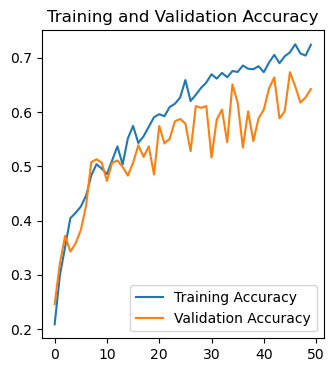

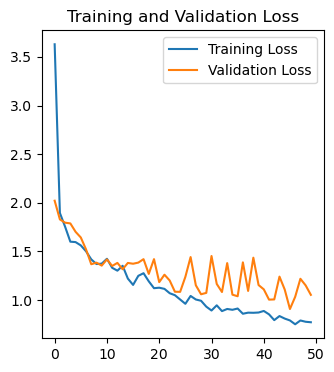

In [32]:
# Plotting Training vs Validation Accuracy
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plotting Training Loss vs Validation loss
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to Predict
Actual label: Metal
Predicted Label: Metal


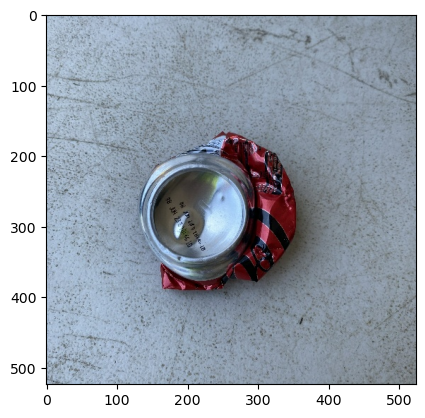

In [33]:
# Making Prediction
for images_batch, labels_batch in test_dataset.take(1):
    
    first_img = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First Image to Predict")
    plt.imshow(first_img)
    
    print("Actual label:", cls_name[first_label])
    
    # Corrected line: use images_batch instead of image_batch
    batch_prediction = model(images_batch)
    print("Predicted Label:", cls_name[np.argmax(batch_prediction[0])])

In [34]:
# Defining the Predicted Class with Confidence (accuracy score)

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    # Create a batch
    
    predictions = model(img_array)
    
    predicted_class = cls_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

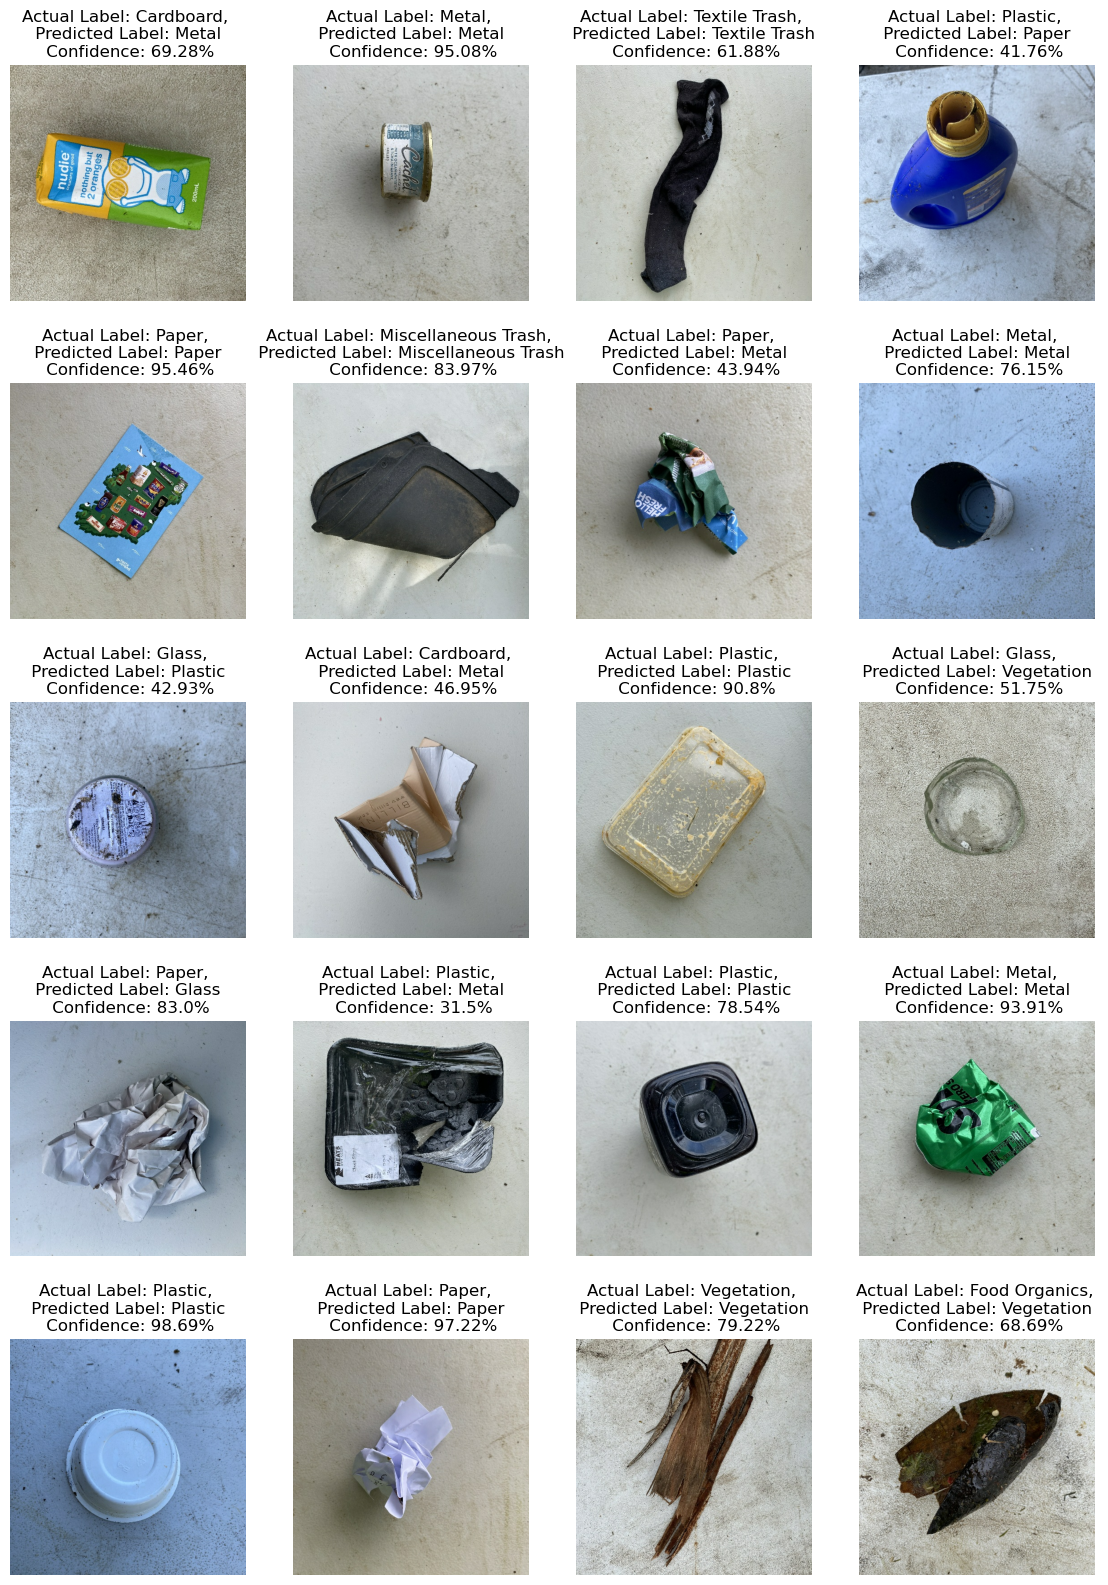

In [38]:
plt.figure(figsize=(14,20))
for images,labels in test_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i+1)             # Defining the rows and columns for displaying
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = cls_name[labels[i]]
        
        plt.title(f"Actual Label: {actual_class}, \n Predicted Label: {predicted_class} \n Confidence: {confidence}%" )
        plt.axis("off")

In [41]:
# Saving the model to a directory

import os
model_version = max([int(i) for i in os.listdir("./Models") + [0]]) + 1
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/1/assets


INFO:tensorflow:Assets written to: ./Models/1/assets
